In [307]:
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
from tslearn.utils import to_time_series_dataset

In [24]:
# load data
orders_df = pd.read_csv('../data/Wholesale_Retail_Orders_Dataset/orders.csv')
product_supplier_df = pd.read_csv('../data/Wholesale_Retail_Orders_Dataset/product-supplier.csv')

In [25]:
# convert to datetime
orders_df['Date Order was placed'] = pd.to_datetime(
    orders_df['Date Order was placed'],
    format = '%d-%b-%y'
)
orders_df['Delivery Date'] = pd.to_datetime(
    orders_df['Delivery Date'],
    format = '%d-%b-%y'
)

In [26]:
orders_df.head(3)

,Customer ID,Customer Status,Date Order was placed,Delivery Date,Order ID,Product ID,Quantity Ordered,Total Retail Price for This Order,Cost Price Per Unit
0,579,Silver,2017-01-01,2017-01-07,123002578,220101400106,2,92.6,20.70
1,7574,SILVER,2017-01-01,2017-01-05,123004074,210201000009,1,21.7,9.95
2,28861,Gold,2017-01-01,2017-01-04,123000871,230100500068,1,1.7,0.80


In [297]:
product_supplier_df.head()

,Product ID,Product Line,Product Category,Product Group,Product Name,Supplier Country,Supplier Name,Supplier ID
0,210100100001,Children,Children Outdoors,"Outdoor things, Kids",Boy's and Girl's Ski Pants with Braces,NO,Scandinavian Clothing A/S,50
1,210100100002,Children,Children Outdoors,"Outdoor things, Kids",Children's Jacket,ES,Luna sastreria S.A.,4742
2,210100100003,Children,Children Outdoors,"Outdoor things, Kids",Children's Jacket Sidney,NO,Scandinavian Clothing A/S,50


In [27]:
# plt.xticks(rotation=70)
# data = {'id': [], 'series': []}
# for product in orders_df['Product ID'].unique()[0:50]:
#     product_cost = orders_df[orders_df['Product ID'] == product] \
#         [['Cost Price Per Unit', 'Date Order was placed']]
#     product_cost = product_cost.set_index('Date Order was placed')
#     product_cost = product_cost.resample('1D').interpolate(method='linear')
    
#     plt.locator_params(axis='x', nbins=10)
#     plt.plot(product_cost.index.values, product_cost['Cost Price Per Unit'], marker='o')

## Кластеризация временных рядов с использованием DTW алгоритма

In [247]:
# prepare data
products = product in data['Product ID'].unique()
data = orders_df.copy()
for product in products:
    product_cost = data[data['Product ID'] == product]['Cost Price Per Unit'].values
    product_cost = minmax_scale(product_cost)
    data.loc[data['Product ID'] == product, 'Cost Price Per Unit'] = product_cost

In [282]:
products = data['Product ID'].unique()
series = [data[data['Product ID'] == product]['Cost Price Per Unit'].values.tolist() for
          product in data['Product ID'].unique()]
train = random.sample(list(zip(products, series)), 200)
train_products = [i[0] for i in train]
train_series = [i[1] for i in train]
X = to_time_series_dataset(train_series)

In [142]:
silhoutte = []
for i in tqdm(range(2, 9)):
    km = TimeSeriesKMeans(
        n_clusters=i,
        metric="dtw",
        max_iter=20,
        max_iter_barycenter=10,
        random_state=0
    ).fit(X)
    y_pred = km.predict(X)
    score = silhouette_score(X, y_pred, metric="dtw")
    silhoutte.append(score)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [13:32<00:00, 116.05s/it]


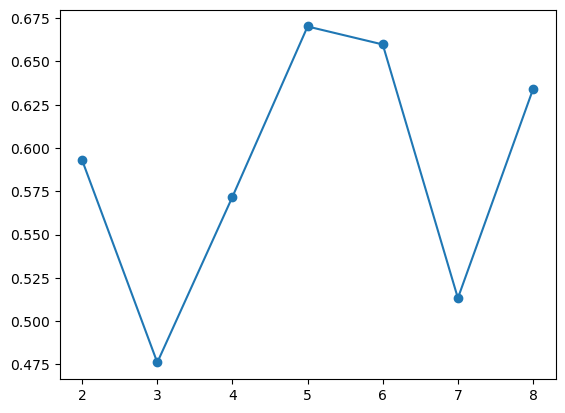

In [143]:
plt.plot(range(2, 9), silhoutte, marker='o')

In [284]:
# train clastirization
n_clasters = 5
km = TimeSeriesKMeans(
    n_clusters=n_clasters,
    metric="dtw",
    max_iter=20,
    max_iter_barycenter=10,
    random_state=0
).fit(X)
y_pred = km.predict(X)

C:\Users\vanya\AppData\Local\Temp\ipykernel_9288\3534621678.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


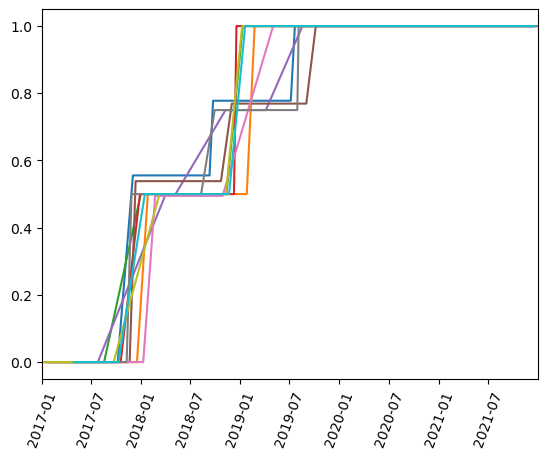

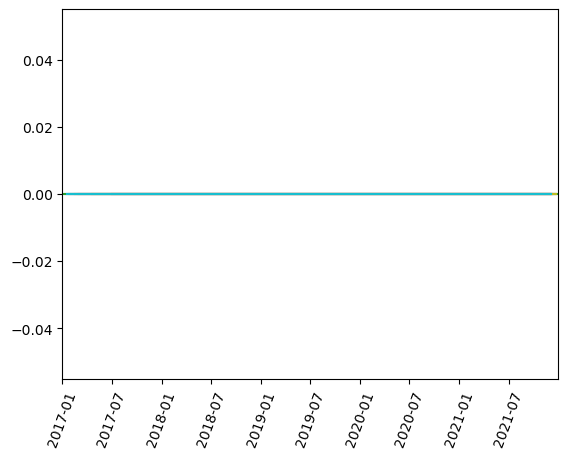

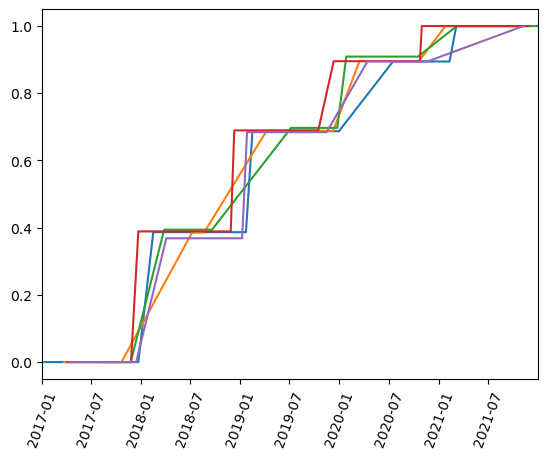

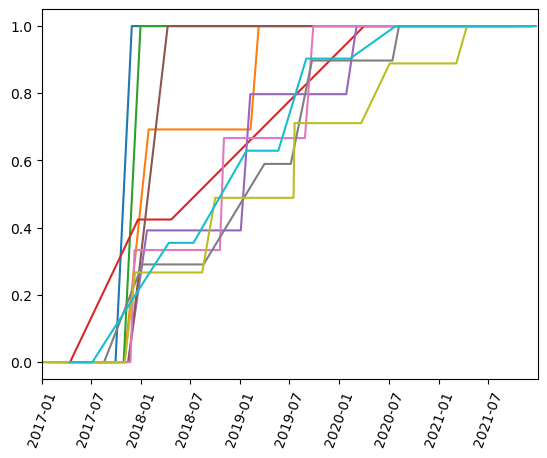

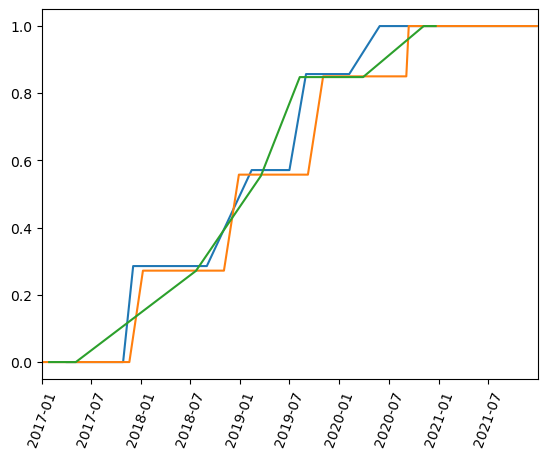

In [296]:
# plot result
for cluster in range(n_clasters):
    indexes = np.where(y_pred == cluster)[0]
    products = [train_products[i] for i in indexes]
    series = [train_series[i] for i in indexes]
    for product, seria in zip(products[:10], series[:10]):

        plt.xticks(rotation=70)
        plt.xlim((data['Date Order was placed'].min(), data['Date Order was placed'].max()))
        plt.locator_params(axis='x', nbins=10)
        plt.plot(
            orders_df[orders_df['Product ID'] == product]['Date Order was placed'].values,
            seria,
            # marker='o'
        )
    plt.show()

## Посмотрим на получившиеся кластеры

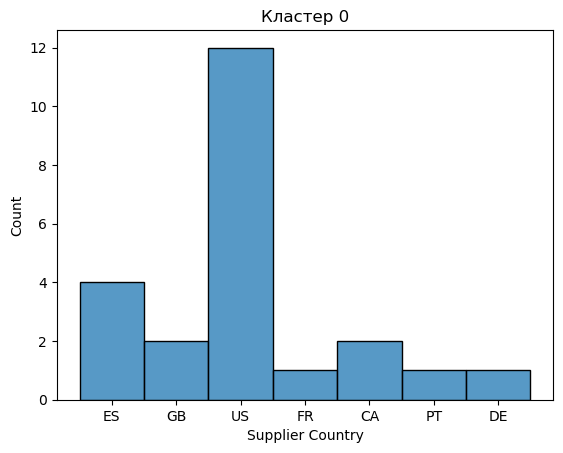

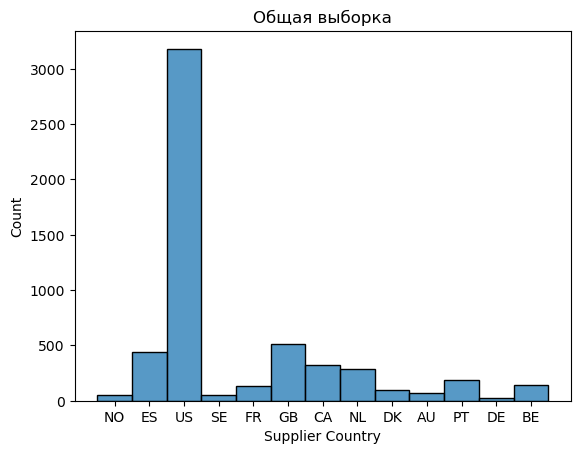

In [334]:
cluster = 0
indexes = np.where(y_pred == cluster)[0]
products = [train_products[i] for i in indexes]
cluster_products = product_supplier_df[product_supplier_df['Product ID'].isin(products)]

plt.title(f'Кластер {cluster}')
sns.histplot(cluster_products['Supplier Country'])
plt.show()

plt.title(f'Общая выборка')
sns.histplot(product_supplier_df['Supplier Country'])
plt.show()